In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns
import pandas as pd

print(tf.__version__)

2.9.2


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 13 02:00:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

from pathlib import Path

local_dir = Path().cwd()
train_dir = local_dir / 'drive/My Drive/CECS456-Final_Project/train'
test_dir = local_dir / 'drive/My Drive/CECS456-Final_Project/test'
val_dir = local_dir / 'drive/My Drive/CECS456-Final_Project/val'

#Reads the data from disk
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, seed=123)
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir, seed=123)
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir, seed=123)

print(train_ds.class_names)
print(val_ds.class_names)
print(test_ds.class_names)



Found 2682 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [5]:
# prints the shape of the training dataset
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 256, 256, 3)
(32,)


In [6]:
# Processes and augments the data
resize_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256, 256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/127.5)
])
data_aug = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
      tf.keras.layers.RandomContrast(0.5),
      tf.keras.layers.RandomCrop(127,255)
])



In [7]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds= val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Building the network
num_classes = 2
model = tf.keras.Sequential([
  data_aug,
  resize_rescale,
  tf.keras.layers.Conv2D(96, 7, strides = 2),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(3, strides = 2),
  tf.keras.layers.Lambda(tf.image.per_image_standardization),
  tf.keras.layers.Conv2D(256, 3),
  tf.keras.layers.Lambda(tf.image.per_image_standardization),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(3, strides = 2),
  tf.keras.layers.Conv2D(384, 3, strides = 1),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Conv2D(384, 3, strides = 1),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Conv2D(256, 3),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(3, strides = 2),
  tf.keras.layers.Lambda(tf.image.per_image_standardization),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4096),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax'),
])

In [9]:
# Compile the model and include metrics
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [11]:
# Training the network
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size = 128,
  epochs=100
)

Epoch 1/20
84/84 [==============================] - 11s 132ms/step - loss: 0.3659 - accuracy: 0.8486 - val_loss: 0.7884 - val_accuracy: 0.5625
Epoch 2/20
84/84 [==============================] - 11s 131ms/step - loss: 0.3638 - accuracy: 0.8490 - val_loss: 0.6012 - val_accuracy: 0.4375
Epoch 3/20
84/84 [==============================] - 11s 134ms/step - loss: 0.3491 - accuracy: 0.8587 - val_loss: 0.9474 - val_accuracy: 0.5625
Epoch 4/20
84/84 [==============================] - 11s 134ms/step - loss: 0.3493 - accuracy: 0.8680 - val_loss: 0.7948 - val_accuracy: 0.5625
Epoch 5/20
84/84 [==============================] - 11s 134ms/step - loss: 0.3507 - accuracy: 0.8546 - val_loss: 0.7608 - val_accuracy: 0.5625
Epoch 6/20
84/84 [==============================] - 11s 135ms/step - loss: 0.3480 - accuracy: 0.8613 - val_loss: 0.7036 - val_accuracy: 0.5625
Epoch 7/20
84/84 [==============================] - 11s 133ms/step - loss: 0.3551 - accuracy: 0.8594 - val_loss: 0.5999 - val_accuracy: 0.5625

In [12]:
# #Image visualization of zfnet model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 127, 255, 3)       0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 125, 125, 96)      14208     
                                                                 
 activation (Activation)     (None, 125, 125, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 96)       0         
 )                                                               
                                                                 
 lambda (Lambda)             (None, 62, 62, 96)        0         
                                                      

In [13]:
# Evaluate the model on each dataset, if desired
score = model.evaluate(test_ds)
score1 = model.evaluate(train_ds)
score2 = model.evaluate(val_ds)

1/1 [==============================] - 0s 14ms/step - loss: 0.8395 - accuracy: 0.6250


In [14]:
# Print the score of each evaluation
print(score)
print(score1)
print(score2)

[0.338936448097229, 0.8621794581413269]
[0.31580662727355957, 0.8866517543792725]
[0.8395440578460693, 0.625]


In [15]:
# Prediction on the test dataset
prediction = model.predict(test_ds)

20/20 [==============================] - 1s 30ms/step


In [16]:
# Creating the confusion matrix
true_pos = 0
false_pos = 0
true_neg = 0
false_neg = 0

for X, y in test_ds:
    batch_pred = model.predict(X, batch_size=32)
    for i in range(len(batch_pred)):
        p = np.argmax(batch_pred[i])
        if p == 1 and y[i] == 1:
            true_pos += 1
        elif p == 1 and y[i] != 1:
            false_pos += 1
        elif p == 0 and y[i] == 0:
            true_neg += 1
        else: 
            false_neg += 1
cn_accuracy = (true_neg + true_pos)/(true_neg+false_pos+true_pos+false_neg)
print(f'True Pos: {true_pos}')
print(f'False Pos: {false_pos}')
print(f'True Neg: {true_neg}')
print(f'False Neg: {false_neg}')
print(f'Accuracy: {cn_accuracy}')

1/1 [==============================] - 0s 194ms/step
True Pos: 331
False Pos: 27
True Neg: 207
False Neg: 59
Accuracy: 0.8621794871794872


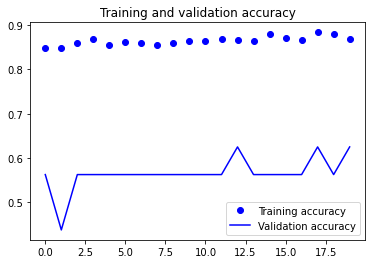

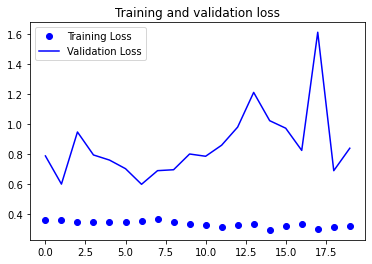

In [17]:
# Plot the accuracy and loss

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the model, if desired
# model.save('drive/My Drive/CECS456-Final_Project/zfnet_91_100epoch')

In [ ]:
#Load the model, if desired

# from tensorflow.keras.models import load_model
# model = load_model('drive/My Drive/CECS456-Final_Project/zfnet_78')